# Nuestras Caras

## Importar librerías para ejecutar notebook

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2
import re

In [2]:
# Preparar las imagenes para ejecucion de la notebook (DEJAR EN FALSE)
PREPARAR_IMAGENES = False


import os
import sys

# Obtener el path de ejecucion de la notebook
current_dir = os.getcwd()

# Define el nombre del proyecto
root_dir_name = "NuestrasCaras"

# Obtiene el path del proyecto
while not os.path.basename(current_dir) == root_dir_name:
    current_dir = os.path.dirname(current_dir)
    
# Obtiene el path de las funciones para 
dir_func_00 = os.path.join(current_dir,"00_preparar_imagenes_entrenamiento")
dir_func_01 = os.path.join(current_dir,"01_entrenar_modelo")
dir_func_02 = os.path.join(current_dir,"02_probar_nuevas_fotos")
dir_func_03 = os.path.join(current_dir,"03_pruebas_entrenamiento_tensorflow")

# Agrega path a librerias
sys.path.append(current_dir)
sys.path.append(dir_func_00)
sys.path.append(dir_func_01)
sys.path.append(dir_func_02)
sys.path.append(dir_func_03)


from preparar_imagenes import preparar_imagenes_entrenamiento
if PREPARAR_IMAGENES:
    dir_imagenes_input_entrenamiento = os.path.join(current_dir,"00_preparar_imagenes_entrenamiento", "imagenes_input_entrenamiento")
    dir_imagenes_output_entrenamiento = os.path.join(current_dir,"01_entrenar_modelo", "fotos_entrenamiento")
    preparar_imagenes_entrenamiento(dir_imagenes_input_entrenamiento, dir_imagenes_output_entrenamiento)

## Importar imagenes para entrenamiento modelo

In [2]:
# Configuración inicial
data_dir = ("fotos_entrenamiento")  # Cambia esto a la ruta de tu directorio de imágenes
nombres = []
imagenes = []

# Cargar imágenes y etiquetas
for archivo in os.listdir(data_dir):
    if archivo.endswith('.jpeg') or archivo.endswith('.jpg'):
        nombre = archivo.split('_')[0].replace(".jpg","").replace(".jpeg","")
        nombre = re.sub(r'\d+', '', nombre)
        ruta_imagen = os.path.join(data_dir, archivo)
        imagen = Image.open(ruta_imagen)
        imagen = np.array(imagen.resize((30, 30)))  # Redimensionar imágenes para un tamaño uniforme
        if len(imagen.shape) == 3 and imagen.shape[2] == 3:
            imagen = cv2.cvtColor(imagen, cv2.COLOR_RGB2GRAY)  # Convertir a escala de grises si es necesario
        imagenes.append(imagen.flatten())
        nombres.append(nombre)

new_images = np.array(imagenes)
nombres_new = np.array(nombres)

# estand
new_images = new_images/255.0

In [3]:
greyscale_values = pd.DataFrame(new_images)
people_names = nombres_new.reshape(-1)

## Dividir en train y test

In [4]:
# Mediante el parametro "stratify" nos aseguramos que se tomen todos los nombres
X_train, X_test, nombres_y_train, nombres_y_test = train_test_split(greyscale_values, people_names, test_size=0.2, random_state=42, stratify=people_names)

# Transformo los nombres a números (0-1) usando label binarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(nombres_y_train)
y_test = label_binarizer.transform(nombres_y_test)
classes = label_binarizer.classes_

In [5]:
# Train
print(X_train.shape)
print(nombres_y_train.shape)


(8367, 900)
(8367,)


In [6]:
# Test
print(X_test.shape)
print(nombres_y_test.shape)


(2092, 900)
(2092,)


In [7]:
# Dimensiones del array
people_names = np.array(people_names)
print(people_names.shape)

greyscale_values = np.array(greyscale_values)
print(greyscale_values.shape)

(10459,)
(10459, 900)


Text(0.5, 1.0, 'joaquin')

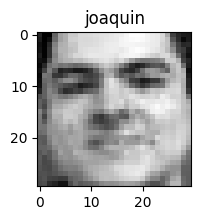

In [8]:
# prueba
plt.figure(figsize=(3, 2))
plt.imshow(np.array(X_train.iloc[0]).reshape(30,30),cmap="gray")
plt.title(nombres_y_train[0])

Text(0.5, 1.0, 'Cara Promedio')

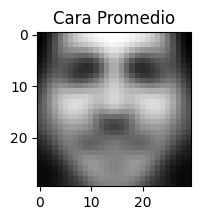

In [9]:
# obtiene y mustra la cara promedio
cara_promedio = np.mean(greyscale_values, axis=0)
cara_promedio.shape
plt.figure(figsize=(3, 2))
plt.imshow(cara_promedio.reshape(30,30),cmap="gray")
plt.title('Cara Promedio')

## Aplicar Análisis de Componentes Principales (PCA)

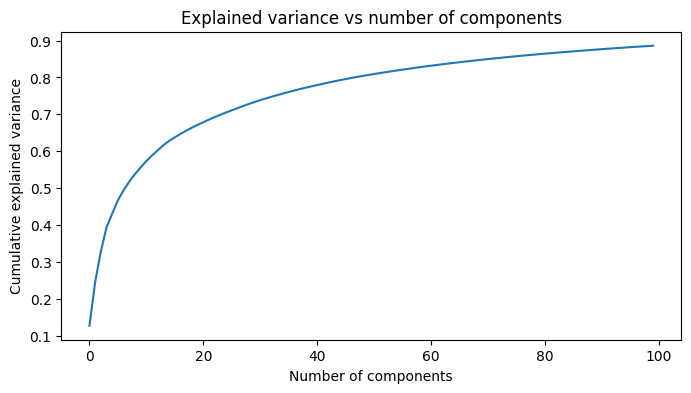

In [10]:
n_pca = 100
pca = PCA(n_components=n_pca, random_state=22).fit(X_train)
X_train_pca = pca.fit_transform(X_train)

eigenfaces = pca.components_
varianza_explicada = pca.explained_variance_ratio_

# plot explained variance (grafico continuo)
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(varianza_explicada))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Explained variance vs number of components')
plt.show()


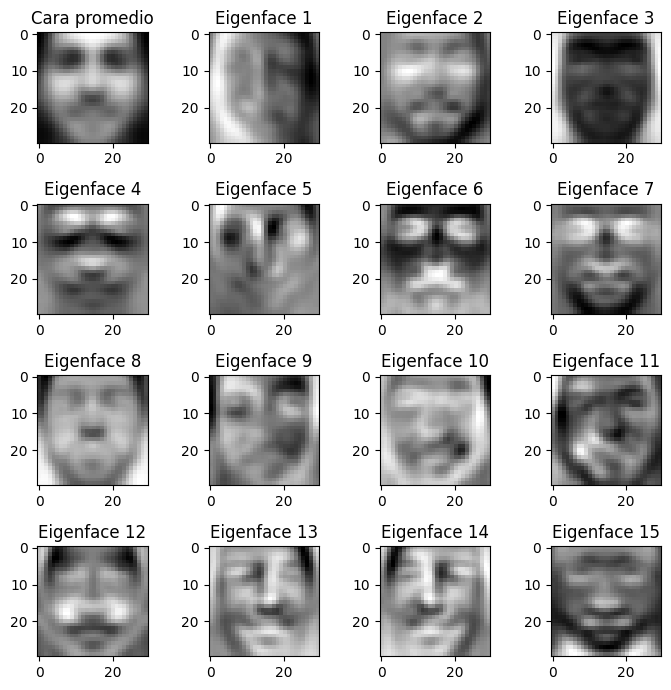

In [11]:
#********************************************************************************************************************
#                    GRAFICO DE LAS PRIMERAS 15 EIGENFACES
#********************************************************************************************************************

fig, ax = plt.subplots(4, 4, figsize=(7, 7))

ax[0, 0].imshow(cara_promedio.reshape(30,30), cmap="gray")
ax[0, 0].set_title("Cara promedio")

for i in range(0,15): # primeras 15 pca
    ax[(i+1) // 4, (i+1) % 4].imshow(eigenfaces[i].reshape(30,30), cmap="gray")
    ax[(i+1) // 4, (i+1) % 4].set_title(f"Eigenface {i+1}")

#plot dimensions
plt.tight_layout()
plt.show()

## Entrenamiento Redes Neuronales

Realizamos las siguientes pruebas:
* Ajusto modelo sin escalamiento de datos
* Ajusto modelo estandarizando
* Ajusto modelo con escalamiento min-max
* Ajusto modelo restando cara promedio
* Ajusto modelo sin escalamiento de datos (pero sin considerar las primeras dos CP)
* Ajusto modelo estandarizando (pero sin considerar las primeras dos CP)
* Ajusto modelo con escalamiento min-max (pero sin considerar las primeras dos CP)
* Ajusto modelo restando cara promedio (pero sin considerar las primeras dos CP)

In [12]:
# importo librerias
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from backpropagation import backpropagation_2_layers, evaluate_predictions

In [13]:
# obtener CPs
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# estandarizar CPs
scaler = StandardScaler()
X_train_pca_scaled = scaler.fit_transform(X_train_pca)
X_test_pca_scaled = scaler.transform(X_test_pca)

# escalamiento 0-1 CPs
scaler_min_max = MinMaxScaler()
X_train_pca_min_max = scaler_min_max.fit_transform(X_train_pca)
X_test_pca_min_max = scaler_min_max.transform(X_test_pca)

# resto cara promedio
cara_promedio_pca = pca.transform(cara_promedio.reshape(1,900)) # cuidado si cambiamos la dim de las fotos! (ahora es 30*30)
X_train_pca_menos_cara_promedio = X_train_pca - cara_promedio_pca
X_test_pca_menos_cara_promedio = X_test_pca - cara_promedio_pca

In [19]:
# Defino de antemano la catidad de neuronas por capa
hidden_size1 = 45
hidden_size2 = 26

## Prueba 1: modelo sin realizar modificaciones de las CPs

In [15]:
# obtener diccionario de pesos de la red
weights_dict = backpropagation_2_layers(X = X_train_pca, Y = y_train, hidden_size1 = hidden_size1, hidden_size2= hidden_size2)

# evaluar modelo base test
df_results = evaluate_predictions(x_new = X_test_pca, y_labels=classes, y_value=np.array(nombres_y_test), weights_dict=weights_dict)

# mostrar mal clasificados
display(df_results[df_results["Nombre de la columna"]!=df_results["Nombre verdadero"]])

# mostrar Error
(df_results[df_results["Nombre de la columna"]==df_results["Nombre verdadero"]]).shape[0] / df_results.shape[0] * 100

Iteracion 10 - Error: 0.000446277969361009
Iteracion 20 - Error: 3.728704442682746e-05
Iteracion 30 - Error: 1.960109140816241e-05
Iteracion 40 - Error: 1.6067178132542856e-05
Iteracion 50 - Error: 1.4122500201607501e-05
Iteracion 60 - Error: 1.284126689079746e-05
Iteracion 70 - Error: 1.1926256716678012e-05
Iteracion 80 - Error: 1.1237691838369612e-05
Iteracion 90 - Error: 1.0699861996075449e-05
Iteracion 100 - Error: 1.0267769248248508e-05
Iteracion 110 - Error: 9.912841882807748e-06
Iteracion 120 - Error: 9.616010209574127e-06
Iteracion 130 - Error: 9.364037163055465e-06
Iteracion 140 - Error: 9.147437091762662e-06
Iteracion 150 - Error: 8.959230321391972e-06
Iteracion 160 - Error: 8.794164713209595e-06
Iteracion 170 - Error: 8.648211202178927e-06
Iteracion 180 - Error: 8.518226723735572e-06
Iteracion 190 - Error: 8.401722977516736e-06
Iteracion 200 - Error: 8.29670411546394e-06


,Valor máximo,Nombre de la columna,Nombre verdadero
10,0.224439,joaquin,carlos
40,0.304728,francoS,carlos
59,0.806810,matias,gustavo
107,0.653698,gerard,francoS
270,0.393397,lisandro,carlos
435,0.495788,matias,gerard
506,0.889412,noelia,lisandro
562,0.958049,victorio,joaquin
598,0.713748,matias,gustavo
752,0.541386,joaquin,victorio


98.7093690248566

## Prueba 2: modelo estandarizando

In [20]:
# obtener diccionario de pesos de la red
weights_dict_scaled = backpropagation_2_layers(X = X_train_pca_scaled, Y = y_train, hidden_size1 = hidden_size1, hidden_size2= hidden_size2)

# evaluar modelo base test
df_results = evaluate_predictions(x_new = X_test_pca_scaled, y_labels=classes, y_value=np.array(nombres_y_test), weights_dict=weights_dict_scaled)

# mostrar mal clasificados
display(df_results[df_results["Nombre de la columna"]!=df_results["Nombre verdadero"]])

# mostrar Error
(df_results[df_results["Nombre de la columna"]==df_results["Nombre verdadero"]]).shape[0] / df_results.shape[0] * 100

Iteracion 10 - Error: 0.0010776876782119184
Iteracion 20 - Error: 0.00011641380068858923
Iteracion 30 - Error: 2.6970215029563126e-05
Iteracion 40 - Error: 2.1990277355933726e-05
Iteracion 50 - Error: 1.9830825524693893e-05
Iteracion 60 - Error: 1.8547361951409583e-05
Iteracion 70 - Error: 1.7678311323678638e-05
Iteracion 80 - Error: 1.7043517261915784e-05
Iteracion 90 - Error: 1.655559161451745e-05
Iteracion 100 - Error: 1.6166535496504328e-05
Iteracion 110 - Error: 1.5847769275070442e-05
Iteracion 120 - Error: 1.5581697061228504e-05
Iteracion 130 - Error: 1.535670098139648e-05
Iteracion 140 - Error: 1.5163962016585332e-05
Iteracion 150 - Error: 1.4996787457445105e-05
Iteracion 160 - Error: 1.4850226722997202e-05
Iteracion 170 - Error: 1.4720578304894462e-05
Iteracion 180 - Error: 1.4605025798666043e-05
Iteracion 190 - Error: 1.4501388884819548e-05
Iteracion 200 - Error: 1.4407944112853286e-05


,Valor máximo,Nombre de la columna,Nombre verdadero
10,0.084969,federicoG,carlos
14,0.938786,gustavo,marco
51,0.924681,lautaro,matias
107,0.842334,matias,francoS
120,0.864574,lisandro,lautaro
...,...,...,...
1935,0.463173,federicoG,juan
1966,0.115638,matias,gerard
1977,0.402183,joaquin,matias
1993,0.991379,matias,carlos


96.74952198852772

## Prueba 3: modelo con escalamiento min-max

In [21]:
# obtener diccionario de pesos de la red
weights_dict_min_max = backpropagation_2_layers(X = X_train_pca_min_max, Y = y_train, hidden_size1 = hidden_size1, hidden_size2= hidden_size2)

# evaluar modelo base test
df_results = evaluate_predictions(x_new = X_test_pca_min_max, y_labels=classes, y_value=np.array(nombres_y_test), weights_dict=weights_dict_min_max)

# mostrar mal clasificados
display(df_results[df_results["Nombre de la columna"]!=df_results["Nombre verdadero"]])

# mostrar Error
(df_results[df_results["Nombre de la columna"]==df_results["Nombre verdadero"]]).shape[0] / df_results.shape[0] * 100

Iteracion 10 - Error: 0.015632196756278294
Iteracion 20 - Error: 0.007972672049131995
Iteracion 30 - Error: 0.021797877663885655
Iteracion 40 - Error: 0.014675253653205926
Iteracion 50 - Error: 0.018083628775440935
Iteracion 60 - Error: 0.013593241241821269
Iteracion 70 - Error: 0.01595801608185628
Iteracion 80 - Error: 0.018003697179055932
Iteracion 90 - Error: 0.018121195633448318
Iteracion 100 - Error: 0.015361394056043438
Iteracion 110 - Error: 0.014976248129658212
Iteracion 120 - Error: 0.019142424754594434
Iteracion 130 - Error: 0.012651462497359149
Iteracion 140 - Error: 0.018647628470289584
Iteracion 150 - Error: 0.012958265425518823
Iteracion 160 - Error: 0.01121954246896307
Iteracion 170 - Error: 0.012837621187423412
Iteracion 180 - Error: 0.014743477136989442
Iteracion 190 - Error: 0.016223419484649303
Iteracion 200 - Error: 0.011419547697305497


,Valor máximo,Nombre de la columna,Nombre verdadero
2,0.663412,noelia,florencia
4,0.234217,florencia,lautaro
10,0.893179,victorio,carlos
13,0.485972,marco,lautaro
18,0.416238,joaquin,victorio
...,...,...,...
2065,0.285505,lautaro,victorio
2076,0.975363,marco,gerard
2084,0.976208,gerard,noelia
2085,0.217016,noelia,florencia


82.74378585086042

## Prueba 4: modelo restando cara promedio

In [22]:
# obtener diccionario de pesos de la red
weights_dict_menos_cara_prom = backpropagation_2_layers(X = X_train_pca_menos_cara_promedio, Y = y_train, hidden_size1 = hidden_size1, hidden_size2= hidden_size2)

# evaluar modelo base test
df_results = evaluate_predictions(x_new = X_test_pca_menos_cara_promedio, y_labels=classes, y_value=np.array(nombres_y_test), weights_dict=weights_dict_menos_cara_prom)

# mostrar mal clasificados
display(df_results[df_results["Nombre de la columna"]!=df_results["Nombre verdadero"]])

# mostrar Error
(df_results[df_results["Nombre de la columna"]==df_results["Nombre verdadero"]]).shape[0] / df_results.shape[0] * 100

Iteracion 10 - Error: 0.00048539811900224974
Iteracion 20 - Error: 3.497431718432768e-05
Iteracion 30 - Error: 2.588496636186659e-05
Iteracion 40 - Error: 2.2365528171840147e-05
Iteracion 50 - Error: 2.0382188206493883e-05
Iteracion 60 - Error: 1.9087577996889017e-05
Iteracion 70 - Error: 1.8169225421452946e-05
Iteracion 80 - Error: 1.7481321189909627e-05
Iteracion 90 - Error: 1.6945673548330735e-05
Iteracion 100 - Error: 1.6516241070723445e-05
Iteracion 110 - Error: 1.6164017228242175e-05
Iteracion 120 - Error: 1.5869762667222216e-05
Iteracion 130 - Error: 1.5620186299246232e-05
Iteracion 140 - Error: 1.540579708510532e-05
Iteracion 150 - Error: 1.5219628352954967e-05
Iteracion 160 - Error: 1.5056445989876489e-05
Iteracion 170 - Error: 1.4912238485525125e-05
Iteracion 180 - Error: 1.4783878003928924e-05
Iteracion 190 - Error: 1.4668888883067399e-05
Iteracion 200 - Error: 1.456528565757955e-05


,Valor máximo,Nombre de la columna,Nombre verdadero
10,0.157253,joaquin,carlos
40,0.627132,francoS,carlos
59,0.893811,matias,gustavo
107,0.030369,lautaro,francoS
270,0.560489,francoS,carlos
321,0.699058,lautaro,victorio
435,0.614209,matias,gerard
506,0.684283,noelia,lisandro
598,0.656032,matias,gustavo
752,0.207880,joaquin,victorio


98.47036328871893

## Prueba 5: modelo sin realizar modificaciones de las CPs (pero sin considerar las primeras dos CP)

In [23]:
# obtener diccionario de pesos de la red
weights_dict_sin_1ras_3cps = backpropagation_2_layers(X = X_train_pca[:,3:], Y = y_train, hidden_size1 = hidden_size1, hidden_size2= hidden_size2)

# evaluar modelo base test
df_results = evaluate_predictions(x_new = X_test_pca[:,3:], y_labels=classes, y_value=np.array(nombres_y_test), weights_dict=weights_dict_sin_1ras_3cps)

# mostrar mal clasificados
display(df_results[df_results["Nombre de la columna"]!=df_results["Nombre verdadero"]])

# mostrar Error
(df_results[df_results["Nombre de la columna"]==df_results["Nombre verdadero"]]).shape[0] / df_results.shape[0] * 100

Iteracion 10 - Error: 0.0016508463843999102
Iteracion 20 - Error: 0.0006410270670684559
Iteracion 30 - Error: 0.00048649200266312085
Iteracion 40 - Error: 0.0004547545120210834
Iteracion 50 - Error: 0.0002956583799191201
Iteracion 60 - Error: 0.00028686554169365784
Iteracion 70 - Error: 0.00028486932315314453
Iteracion 80 - Error: 0.0002836375889563404
Iteracion 90 - Error: 0.0003426837204023608
Iteracion 100 - Error: 0.00023205254648700832
Iteracion 110 - Error: 0.00019616868370663662
Iteracion 120 - Error: 0.0001883519463424391
Iteracion 130 - Error: 0.00018723034636060248
Iteracion 140 - Error: 0.00018653887800028525
Iteracion 150 - Error: 0.00018605270052326502
Iteracion 160 - Error: 0.00018568691151761736
Iteracion 170 - Error: 0.00018539926983077498
Iteracion 180 - Error: 0.00018516570900573633
Iteracion 190 - Error: 0.00018497137571493088
Iteracion 200 - Error: 0.00018480655211526492


,Valor máximo,Nombre de la columna,Nombre verdadero
10,0.016268,joaquin,carlos
40,0.762469,francoS,carlos
107,0.168865,natalia,francoS
206,0.478375,florencia,noelia
359,0.993598,victorio,joaquin
401,0.004454,florencia,gerard
435,0.134188,francoS,gerard
471,0.064164,gustavo,matias
501,0.674799,florencia,paola
506,0.090271,noelia,lisandro


97.75334608030593

## Prueba 6: modelo estandarizando (pero sin considerar las primeras dos CP)

In [24]:
# obtener diccionario de pesos de la red
weights_dict_scaled_sin_1ras_3cps = backpropagation_2_layers(X = X_train_pca_scaled[:,3:], Y = y_train, hidden_size1 = hidden_size1, hidden_size2= hidden_size2)

# evaluar modelo base test
df_results = evaluate_predictions(x_new = X_test_pca_scaled[:,3:], y_labels=classes, y_value=np.array(nombres_y_test), weights_dict=weights_dict_scaled_sin_1ras_3cps)

# mostrar mal clasificados
display(df_results[df_results["Nombre de la columna"]!=df_results["Nombre verdadero"]])

# mostrar Error
(df_results[df_results["Nombre de la columna"]==df_results["Nombre verdadero"]]).shape[0] / df_results.shape[0] * 100

Iteracion 10 - Error: 0.004614790071361157
Iteracion 20 - Error: 0.003549169054811117
Iteracion 30 - Error: 0.002436412399134406
Iteracion 40 - Error: 0.0018613994255438145
Iteracion 50 - Error: 0.0023928668829709737
Iteracion 60 - Error: 0.0020899848166227035
Iteracion 70 - Error: 0.0020206410368740864
Iteracion 80 - Error: 0.0017252185625163514
Iteracion 90 - Error: 0.0013446501091778826
Iteracion 100 - Error: 0.0013857303313247406
Iteracion 110 - Error: 0.0019650256371686065
Iteracion 120 - Error: 0.001796519210300351
Iteracion 130 - Error: 0.0015639919234876369
Iteracion 140 - Error: 0.0015322147019490504
Iteracion 150 - Error: 0.0013188870773877556
Iteracion 160 - Error: 0.002176115001141467
Iteracion 170 - Error: 0.0014884682228959788
Iteracion 180 - Error: 0.0013390613356989683
Iteracion 190 - Error: 0.0012820610283393234
Iteracion 200 - Error: 0.0017879943091368058


,Valor máximo,Nombre de la columna,Nombre verdadero
0,0.982466,florencia,paola
1,0.169620,natalia,federicoR
10,0.928811,noelia,carlos
20,0.180856,florencia,victorio
26,0.477191,lautaro,joaquin
...,...,...,...
2032,0.997906,lisandro,matias
2048,0.011040,federicoR,francoS
2057,0.999970,victorio,marco
2065,0.892353,joaquin,victorio


89.62715105162525

## Prueba 7: modelo con escalamiento min-max (pero sin considerar las primeras dos CP)

In [25]:
# obtener diccionario de pesos de la red
weights_dict_min_max_sin_1ras_3cps = backpropagation_2_layers(X = X_train_pca_min_max[:,3:], Y = y_train, hidden_size1 = hidden_size1, hidden_size2= hidden_size2)

# evaluar modelo base test
df_results = evaluate_predictions(x_new = X_test_pca_min_max[:,3:], y_labels=classes, y_value=np.array(nombres_y_test), weights_dict=weights_dict_min_max_sin_1ras_3cps)

# mostrar mal clasificados
display(df_results[df_results["Nombre de la columna"]!=df_results["Nombre verdadero"]])

# mostrar Error
(df_results[df_results["Nombre de la columna"]==df_results["Nombre verdadero"]]).shape[0] / df_results.shape[0] * 100

Iteracion 10 - Error: 0.021381705070379946
Iteracion 20 - Error: 0.016746853896517814
Iteracion 30 - Error: 0.03845204939527576
Iteracion 40 - Error: 0.025710787598464468
Iteracion 50 - Error: 0.031146188210306257
Iteracion 60 - Error: 0.016367880019126063
Iteracion 70 - Error: 0.014787588733685027
Iteracion 80 - Error: 0.019555398832533686
Iteracion 90 - Error: 0.019368636500485644
Iteracion 100 - Error: 0.017291890370752995
Iteracion 110 - Error: 0.01653170981395357
Iteracion 120 - Error: 0.02139741206352242
Iteracion 130 - Error: 0.016423705082921538
Iteracion 140 - Error: 0.018640119444207293
Iteracion 150 - Error: 0.023037904586093855
Iteracion 160 - Error: 0.01699322974759927
Iteracion 170 - Error: 0.022480335864208056
Iteracion 180 - Error: 0.015718879104379618
Iteracion 190 - Error: 0.02075127885057042
Iteracion 200 - Error: 0.02145977731704338


,Valor máximo,Nombre de la columna,Nombre verdadero
0,0.392012,florencia,paola
1,0.267562,matias,federicoR
2,0.086904,noelia,florencia
4,0.476581,paola,lautaro
10,0.985385,francoA,carlos
...,...,...,...
2083,0.284653,florencia,federicoR
2084,0.758232,francoA,noelia
2085,0.098502,gerard,florencia
2090,0.076972,federicoR,carlos


67.78202676864244

## Prueba 8: modelo restando cara promedio (pero sin considerar las primeras dos CP)

In [26]:
# obtener diccionario de pesos de la red
weights_dict_menos_cara_prom_sin_1ras_3cps = backpropagation_2_layers(X = X_train_pca_menos_cara_promedio[:,3:], Y = y_train, hidden_size1 = hidden_size1, hidden_size2= hidden_size2)

# evaluar modelo base test
df_results = evaluate_predictions(x_new = X_test_pca_menos_cara_promedio[:,3:], y_labels=classes, y_value=np.array(nombres_y_test), weights_dict=weights_dict_menos_cara_prom_sin_1ras_3cps)

# mostrar mal clasificados
display(df_results[df_results["Nombre de la columna"]!=df_results["Nombre verdadero"]])

# mostrar Error
(df_results[df_results["Nombre de la columna"]==df_results["Nombre verdadero"]]).shape[0] / df_results.shape[0] * 100

Iteracion 10 - Error: 0.0020946687440841264
Iteracion 20 - Error: 0.000688008006360252
Iteracion 30 - Error: 0.0005535610109759576
Iteracion 40 - Error: 0.0005092841254559918
Iteracion 50 - Error: 0.0004961376839819376
Iteracion 60 - Error: 0.0004937033350434187
Iteracion 70 - Error: 0.0004922392667461033
Iteracion 80 - Error: 0.0004912016205562403
Iteracion 90 - Error: 0.0004904191276913446
Iteracion 100 - Error: 0.0004898044387108543
Iteracion 110 - Error: 0.0004893071056932204
Iteracion 120 - Error: 0.000488895562985804
Iteracion 130 - Error: 0.0004885488680521873
Iteracion 140 - Error: 0.00048825249816368153
Iteracion 150 - Error: 0.00048799602857683657
Iteracion 160 - Error: 0.0004877717643046886
Iteracion 170 - Error: 0.0004875738915970895
Iteracion 180 - Error: 0.0004873979294716822
Iteracion 190 - Error: 0.00048724036248609084
Iteracion 200 - Error: 0.000487098386333175


,Valor máximo,Nombre de la columna,Nombre verdadero
10,0.155741,francoS,carlos
45,0.292363,juan,federicoR
72,0.758050,joaquin,paola
79,0.885881,federicoG,abel
82,0.864697,victorio,joaquin
121,0.091302,lisandro,federicoR
153,0.364514,noelia,paola
206,0.261129,florencia,noelia
241,0.023387,federicoR,matias
257,0.108635,noelia,lisandro


97.131931166348

## Prediccion nuevas caras

## Importar imagenes para testeo prediccion nuevas caras

In [27]:
# Configuración inicial
data_dir = ("fotos_test_entrenamiento")  # Cambia esto a la ruta de tu directorio de imágenes
nombres = []
imagenes = []

# Cargar imágenes y etiquetas
for archivo in os.listdir(data_dir):
    if archivo.endswith('.jpeg') or archivo.endswith('.jpg'):
        nombre = archivo.split('_')[0].replace(".jpg","").replace(".jpeg","")
        nombre = re.sub(r'\d+', '', nombre)
        ruta_imagen = os.path.join(data_dir, archivo)
        imagen = Image.open(ruta_imagen)
        imagen = np.array(imagen.resize((30, 30)))  # Redimensionar imágenes para un tamaño uniforme
        if len(imagen.shape) == 3 and imagen.shape[2] == 3:
            imagen = cv2.cvtColor(imagen, cv2.COLOR_RGB2GRAY)  # Convertir a escala de grises si es necesario
        imagenes.append(imagen.flatten())
        nombres.append(nombre)

new_images_test = np.array(imagenes)
nombres_new_test = np.array(nombres)

# estand
new_images_test = new_images_test/255.0

In [28]:
greyscale_values_predict = pd.DataFrame(new_images_test)
people_names_predict = nombres_new_test.reshape(-1)

In [29]:
# definir X_new, nombres_y_new, y_new
X_new, nombres_y_new = greyscale_values_predict, people_names_predict
y_new = label_binarizer.transform(nombres_y_new)

In [30]:
print(X_new.shape)
nombres_y_new

(30, 900)


array(['federicoG', 'federicoG', 'federicoG', 'federicoG', 'federicoG',
       'federicoG', 'federicoG', 'federicoG', 'federicoG', 'federicoR',
       'federicoR', 'federicoR', 'florencia', 'florencia', 'florencia',
       'florencia', 'florencia', 'lautaro', 'lautaro', 'lautaro',
       'lautaro', 'lautaro', 'lisandro', 'lisandro', 'paola', 'paola',
       'paola', 'paola', 'paola', 'paola'], dtype='<U9')

In [31]:
# aplicar pca y escalado de datos

# obtener CPs
X_new_pca = pca.transform(X_new)

# estandarizar CPs
X_new_pca_scaled = scaler.transform(X_new_pca)

# escalamiento 0-1 CPs
X_new_pca_min_max = scaler_min_max.transform(X_new_pca)

# resto cara promedio
X_new_pca_menos_cara_promedio = X_new_pca - cara_promedio_pca

## Prueba 1:  modelo sin escalamiento de datos (solo CPs)

In [32]:
# obtenemos predicciones
df_results_predict = evaluate_predictions(x_new = X_new_pca, y_labels=classes, y_value=np.array(nombres_y_new), weights_dict=weights_dict)

# mostrar bien clasificados
display(df_results_predict[df_results_predict["Nombre de la columna"]==df_results_predict["Nombre verdadero"]])

# mostrar mal clasificados
display(df_results_predict[df_results_predict["Nombre de la columna"]!=df_results_predict["Nombre verdadero"]])

# mostrar Error
(df_results_predict[df_results_predict["Nombre de la columna"]==df_results_predict["Nombre verdadero"]]).shape[0] / df_results_predict.shape[0] * 100

,Valor máximo,Nombre de la columna,Nombre verdadero
0,0.906407,federicoG,federicoG
1,0.994969,federicoG,federicoG
2,0.408776,federicoG,federicoG
3,0.950023,federicoG,federicoG
4,0.441712,federicoG,federicoG
5,0.950023,federicoG,federicoG
6,0.441712,federicoG,federicoG
7,0.408776,federicoG,federicoG
8,0.994969,federicoG,federicoG
9,0.997938,federicoR,federicoR


,Valor máximo,Nombre de la columna,Nombre verdadero
12,0.353228,noelia,florencia
13,0.996628,gustavo,florencia
15,0.996628,gustavo,florencia
16,0.353228,noelia,florencia
17,0.945497,victorio,lautaro
19,0.027690,lisandro,lautaro
20,0.039039,paola,lautaro
23,0.911467,marco,lisandro


73.33333333333333

## Prueba 2: modelo estandarizando

In [33]:
# obtenemos predicciones
df_results_predict = evaluate_predictions(x_new = X_new_pca_scaled, y_labels=classes, y_value=np.array(nombres_y_new), weights_dict=weights_dict_scaled)

# mostrar bien clasificados
display(df_results_predict[df_results_predict["Nombre de la columna"]==df_results_predict["Nombre verdadero"]])

# mostrar mal clasificados
display(df_results_predict[df_results_predict["Nombre de la columna"]!=df_results_predict["Nombre verdadero"]])

# mostrar Error
(df_results_predict[df_results_predict["Nombre de la columna"]==df_results_predict["Nombre verdadero"]]).shape[0] / df_results_predict.shape[0] * 100

,Valor máximo,Nombre de la columna,Nombre verdadero
0,0.991116,federicoG,federicoG
1,0.995138,federicoG,federicoG
3,0.968842,federicoG,federicoG
4,0.986263,federicoG,federicoG
5,0.968842,federicoG,federicoG
6,0.986263,federicoG,federicoG
8,0.995138,federicoG,federicoG
9,0.997953,federicoR,federicoR
11,0.193385,federicoR,federicoR
14,0.809551,florencia,florencia


,Valor máximo,Nombre de la columna,Nombre verdadero
2,0.906099,federicoR,federicoG
7,0.906099,federicoR,federicoG
10,0.927150,natalia,federicoR
12,0.926347,gustavo,florencia
13,0.682013,gustavo,florencia
15,0.682013,gustavo,florencia
16,0.926347,gustavo,florencia
17,0.875531,victorio,lautaro
18,0.226336,marco,lautaro
19,0.959742,lisandro,lautaro


56.666666666666664

## Prueba 3: modelo con escalamiento min-max

In [34]:
# obtenemos predicciones
df_results_predict = evaluate_predictions(x_new = X_new_pca_min_max, y_labels=classes, y_value=np.array(nombres_y_new), weights_dict=weights_dict_min_max)

# mostrar bien clasificados
display(df_results_predict[df_results_predict["Nombre de la columna"]==df_results_predict["Nombre verdadero"]])

# mostrar mal clasificados
display(df_results_predict[df_results_predict["Nombre de la columna"]!=df_results_predict["Nombre verdadero"]])

# mostrar Error
(df_results_predict[df_results_predict["Nombre de la columna"]==df_results_predict["Nombre verdadero"]]).shape[0] / df_results_predict.shape[0] * 100

,Valor máximo,Nombre de la columna,Nombre verdadero
0,0.906028,federicoG,federicoG
2,0.291398,federicoG,federicoG
3,0.432813,federicoG,federicoG
5,0.432813,federicoG,federicoG
7,0.291398,federicoG,federicoG
12,0.577760,florencia,florencia
16,0.577760,florencia,florencia
22,0.977293,lisandro,lisandro
25,0.639126,paola,paola
27,0.639126,paola,paola


,Valor máximo,Nombre de la columna,Nombre verdadero
1,0.547141,marco,federicoG
4,0.998810,marco,federicoG
6,0.998810,marco,federicoG
8,0.547141,marco,federicoG
9,0.078544,francoA,federicoR
10,0.365871,carlos,federicoR
11,0.117132,gerard,federicoR
13,0.928805,gustavo,florencia
14,0.874738,gustavo,florencia
15,0.928805,gustavo,florencia


36.666666666666664

## Prueba 4: modelo restando cara promedio

In [35]:
# obtenemos predicciones
df_results_predict = evaluate_predictions(x_new = X_new_pca_menos_cara_promedio, y_labels=classes, y_value=np.array(nombres_y_new), weights_dict=weights_dict_menos_cara_prom)

# mostrar bien clasificados
display(df_results_predict[df_results_predict["Nombre de la columna"]==df_results_predict["Nombre verdadero"]])

# mostrar mal clasificados
display(df_results_predict[df_results_predict["Nombre de la columna"]!=df_results_predict["Nombre verdadero"]])

# mostrar Error
(df_results_predict[df_results_predict["Nombre de la columna"]==df_results_predict["Nombre verdadero"]]).shape[0] / df_results_predict.shape[0] * 100

,Valor máximo,Nombre de la columna,Nombre verdadero
0,0.641944,federicoG,federicoG
1,0.993252,federicoG,federicoG
2,0.605166,federicoG,federicoG
3,0.996714,federicoG,federicoG
4,0.814858,federicoG,federicoG
5,0.996714,federicoG,federicoG
6,0.814858,federicoG,federicoG
7,0.605166,federicoG,federicoG
8,0.993252,federicoG,federicoG
9,0.987154,federicoR,federicoR


,Valor máximo,Nombre de la columna,Nombre verdadero
11,0.870838,francoA,federicoR
12,0.599954,gustavo,florencia
13,0.884297,gustavo,florencia
15,0.884297,gustavo,florencia
16,0.599954,gustavo,florencia
17,0.983148,victorio,lautaro
19,0.075000,matias,lautaro
20,0.489763,matias,lautaro
21,0.738306,francoA,lautaro
23,0.430291,marco,lisandro


66.66666666666666

## Prueba 5: sin escalamiento de datos (pero sin considerar las primeras dos CP)

In [36]:
# obtenemos predicciones
df_results_predict = evaluate_predictions(x_new = X_new_pca[:,3:], y_labels=classes, y_value=np.array(nombres_y_new), weights_dict=weights_dict_sin_1ras_3cps)

# mostrar bien clasificados
display(df_results_predict[df_results_predict["Nombre de la columna"]==df_results_predict["Nombre verdadero"]])

# mostrar mal clasificados
display(df_results_predict[df_results_predict["Nombre de la columna"]!=df_results_predict["Nombre verdadero"]])

# mostrar Error
(df_results_predict[df_results_predict["Nombre de la columna"]==df_results_predict["Nombre verdadero"]]).shape[0] / df_results_predict.shape[0] * 100

,Valor máximo,Nombre de la columna,Nombre verdadero
1,0.995834,federicoG,federicoG
4,0.962693,federicoG,federicoG
6,0.962693,federicoG,federicoG
8,0.995834,federicoG,federicoG
12,0.999041,florencia,florencia
13,0.700668,florencia,florencia
15,0.700668,florencia,florencia
16,0.999041,florencia,florencia
19,0.996100,lautaro,lautaro
22,0.975412,lisandro,lisandro


,Valor máximo,Nombre de la columna,Nombre verdadero
0,0.825751,victorio,federicoG
2,0.542459,victorio,federicoG
3,0.038236,gustavo,federicoG
5,0.038236,gustavo,federicoG
7,0.542459,victorio,federicoG
9,0.272291,francoA,federicoR
10,0.996758,francoA,federicoR
11,0.869417,francoA,federicoR
14,0.465980,abel,florencia
17,0.616314,victorio,lautaro


53.333333333333336

## Prueba 6: modelo estandarizando (pero sin considerar las primeras dos CP)

In [37]:
# obtenemos predicciones
df_results_predict = evaluate_predictions(x_new = X_new_pca_scaled[:,3:], y_labels=classes, y_value=np.array(nombres_y_new), weights_dict=weights_dict_scaled_sin_1ras_3cps)

# mostrar bien clasificados
display(df_results_predict[df_results_predict["Nombre de la columna"]==df_results_predict["Nombre verdadero"]])

# mostrar mal clasificados
display(df_results_predict[df_results_predict["Nombre de la columna"]!=df_results_predict["Nombre verdadero"]])

# mostrar Error
(df_results_predict[df_results_predict["Nombre de la columna"]==df_results_predict["Nombre verdadero"]]).shape[0] / df_results_predict.shape[0] * 100

,Valor máximo,Nombre de la columna,Nombre verdadero
1,0.998093,federicoG,federicoG
2,0.570294,federicoG,federicoG
7,0.570294,federicoG,federicoG
8,0.998093,federicoG,federicoG
12,0.962389,florencia,florencia
13,0.994313,florencia,florencia
15,0.994313,florencia,florencia
16,0.962389,florencia,florencia
17,0.999710,lautaro,lautaro
22,0.995349,lisandro,lisandro


,Valor máximo,Nombre de la columna,Nombre verdadero
0,0.367857,marco,federicoG
3,0.132407,gustavo,federicoG
4,0.078435,noelia,federicoG
5,0.132407,gustavo,federicoG
6,0.078435,noelia,federicoG
9,0.267409,francoA,federicoR
10,0.979138,natalia,federicoR
11,0.999466,francoA,federicoR
14,0.999618,paola,florencia
18,0.998333,victorio,lautaro


53.333333333333336

## Prueba 7: modelo con escalamiento min-max (pero sin considerar las primeras dos CP)

In [38]:
# obtenemos predicciones
df_results_predict = evaluate_predictions(x_new = X_new_pca_min_max[:,3:], y_labels=classes, y_value=np.array(nombres_y_new), weights_dict=weights_dict_min_max_sin_1ras_3cps)

# mostrar bien clasificados
display(df_results_predict[df_results_predict["Nombre de la columna"]==df_results_predict["Nombre verdadero"]])

# mostrar mal clasificados
display(df_results_predict[df_results_predict["Nombre de la columna"]!=df_results_predict["Nombre verdadero"]])

# mostrar Error
(df_results_predict[df_results_predict["Nombre de la columna"]==df_results_predict["Nombre verdadero"]]).shape[0] / df_results_predict.shape[0] * 100

,Valor máximo,Nombre de la columna,Nombre verdadero
1,0.275233,federicoG,federicoG
8,0.275233,federicoG,federicoG
12,0.852767,florencia,florencia
14,0.753747,florencia,florencia
16,0.852767,florencia,florencia
22,0.953062,lisandro,lisandro
24,0.436484,paola,paola
25,0.910218,paola,paola
26,0.913332,paola,paola
27,0.910218,paola,paola


,Valor máximo,Nombre de la columna,Nombre verdadero
0,0.480531,gustavo,federicoG
2,0.149306,paola,federicoG
3,0.489720,gustavo,federicoG
4,0.742185,gustavo,federicoG
5,0.489720,gustavo,federicoG
6,0.742185,gustavo,federicoG
7,0.149306,paola,federicoG
9,0.985888,natalia,federicoR
10,0.609340,matias,federicoR
11,0.982718,natalia,federicoR


40.0

## Prueba 8: modelo restando cara promedio (pero sin considerar las primeras dos CP)

In [39]:
# obtenemos predicciones
df_results_predict = evaluate_predictions(x_new = X_new_pca_menos_cara_promedio[:,3:], y_labels=classes, y_value=np.array(nombres_y_new), weights_dict=weights_dict_menos_cara_prom_sin_1ras_3cps)

# mostrar bien clasificados
display(df_results_predict[df_results_predict["Nombre de la columna"]==df_results_predict["Nombre verdadero"]])

# mostrar mal clasificados
display(df_results_predict[df_results_predict["Nombre de la columna"]!=df_results_predict["Nombre verdadero"]])

# mostrar Error
(df_results_predict[df_results_predict["Nombre de la columna"]==df_results_predict["Nombre verdadero"]]).shape[0] / df_results_predict.shape[0] * 100

,Valor máximo,Nombre de la columna,Nombre verdadero
1,0.998514,federicoG,federicoG
4,0.189163,federicoG,federicoG
6,0.189163,federicoG,federicoG
8,0.998514,federicoG,federicoG
9,0.653285,federicoR,federicoR
12,0.938479,florencia,florencia
13,0.997631,florencia,florencia
15,0.997631,florencia,florencia
16,0.938479,florencia,florencia
19,0.993105,lautaro,lautaro


,Valor máximo,Nombre de la columna,Nombre verdadero
0,0.784155,marco,federicoG
2,0.029435,gerard,federicoG
3,0.120273,gustavo,federicoG
5,0.120273,gustavo,federicoG
7,0.029435,gerard,federicoG
10,0.998339,francoA,federicoR
11,0.983855,francoA,federicoR
14,0.820771,abel,florencia
17,0.959161,victorio,lautaro
18,0.947154,victorio,lautaro


56.666666666666664

## Guardar "mejor" modelo (pca y estand)

In [40]:
import joblib
import pickle

# Guardar el scaler y la PCA
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(pca, 'pca.pkl')
joblib.dump(label_binarizer, 'label_binarizer.pkl')
joblib.dump(scaler_min_max, 'scaler_min_max.pkl')
joblib.dump(cara_promedio_pca, 'cara_promedio_pca.pkl')

# Guardar el diccionario con los pesos de la red neuronal en un archivo pickle
with open('weights_dict.pkl', 'wb') as archivo:
    pickle.dump(weights_dict, archivo)